In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from bresenham import bresenham
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
from sklearn.neighbors import KDTree
from planning_utils import heuristic, create_grid
%matplotlib inline 
import sys
# ! pip install -I networkx==2.1
import pkg_resources
# pkg_resources.require("networkx==2.1")
import networkx as nx
print(nx.__version__)
plt.rcParams['figure.figsize'] = 14, 14

2.1
2.1


In [2]:
with open("colliders.csv") as datafile:
    line = datafile.readline().strip()

spoint = line.split(', ')
lat0 = float(spoint[0].split(' ')[1])
lon0 = float(spoint[1].split(' ')[1])
print(lat0 , lon0)


37.79248 -122.39745


In [3]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

In [4]:
def create_grid_vor(data, drone_altitude, safety_distance):
    """
    Returns a grid representation of a 2D configuration space
    based on given obstacle data, drone altitude and safety distance
    arguments.
    """
    centres = []
    
    # minimum and maximum north coordinates
    north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.max(data[:, 0] + data[:, 3]))

    # minimum and maximum east coordinates
    east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.max(data[:, 1] + data[:, 4]))

    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil(north_max - north_min))
    east_size = int(np.ceil(east_max - east_min))

    # Initialize an empty grid
    grid = np.zeros((north_size, east_size))

    # Populate the grid with obstacles
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        if alt + d_alt + safety_distance > drone_altitude:
            obstacle = [
                int(np.clip(north - d_north - safety_distance - north_min, 0, north_size-1)),
                int(np.clip(north + d_north + safety_distance - north_min, 0, north_size-1)),
                int(np.clip(east - d_east - safety_distance - east_min, 0, east_size-1)),
                int(np.clip(east + d_east + safety_distance - east_min, 0, east_size-1)),
            ]
            centre_i = [north - north_min , east - east_min]
            centres.append(centre_i)
            grid[obstacle[0]:obstacle[1]+1, obstacle[2]:obstacle[3]+1] = 1

    return grid, centres, int(north_min), int(east_min)

In [5]:
grid , centres, north_min, east_min = create_grid_vor(data, 5, 5)

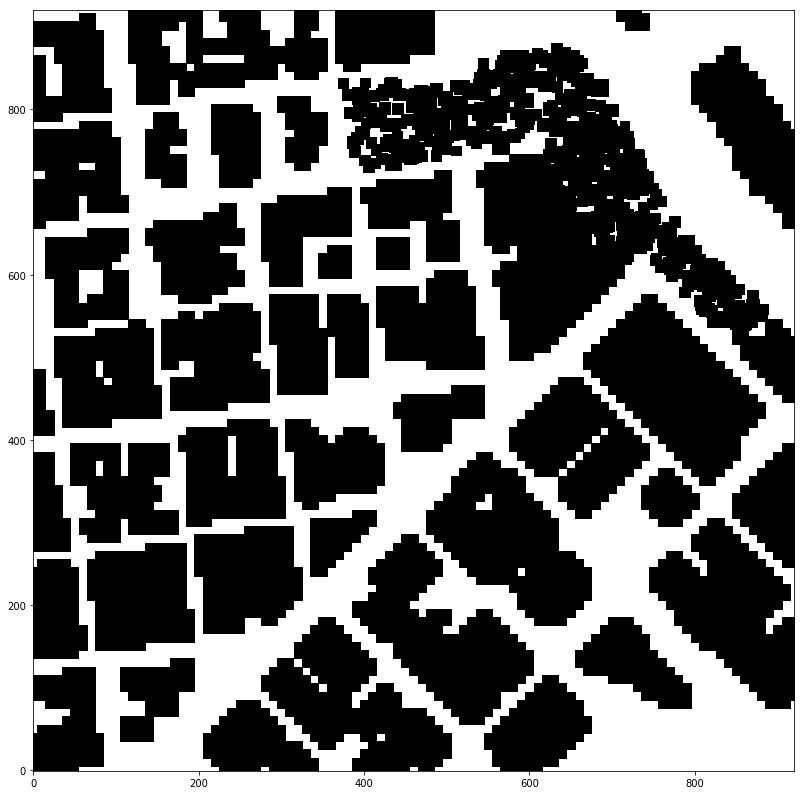

In [12]:
plt.imshow(grid, origin='lower', cmap='Greys')

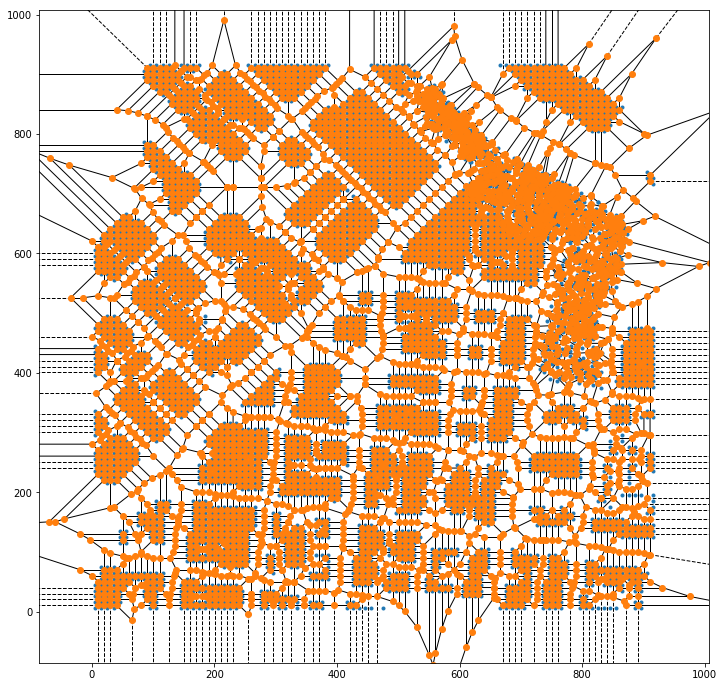

In [6]:
plt.rcParams["figure.figsize"] = [12, 12]
vor_graph = Voronoi(centres)
voronoi_plot_2d(vor_graph)
plt.show()

In [8]:
def create_graph(vor_graph, grid):
    edges = []
    gr = nx.Graph()
    for v in vor_graph.ridge_vertices:
        p1 = vor_graph.vertices[v[0]]
        p2 = vor_graph.vertices[v[1]]
        cells = list(bresenham(int(p1[0]), int(p1[1]), int(p2[0]), int(p2[1])))
        hit = False

        for c in cells:
            # First check if we're off the map
            if np.amin(c) < 0 or c[0] >= grid.shape[0] or c[1] >= grid.shape[1]:
                hit = True
                break
            # Next check if we're in collision
            if grid[c[0], c[1]] == 1:
                hit = True
                break

        # If the edge does not hit on obstacle
        # add it to the list
        if not hit:
            # array to tuple for future graph creation step)
            p1 = (p1[0], p1[1])
            p2 = (p2[0], p2[1])
            edges.append((p1, p2))
            gr.add_edge(p1, p2, weight=1)

    return edges, gr

In [9]:
edges, graph = create_graph(vor_graph, grid)

In [10]:
def closest_point(graph, current_point):
    """
    Compute the closest point in the `graph`
    to the `current_point`.
    """
    closest_point = None
    dist = 100000
    for p in graph.nodes:
        d = LA.norm(np.array(p) - np.array(current_point))
        if d < dist:
            closest_point = p
            dist = d
    return closest_point

In [11]:
start_ne = [100,127]
goal_ne = [234,890]
start_ne_g = closest_point(graph, start_ne)
goal_ne_g = closest_point(graph, goal_ne)
print(start_ne_g)
print(goal_ne_g)

(80.761099999999999, 130.76850000000002)
(242.76109539953967, 902.7685254002937)


In [12]:
# A* algorithm
from queue import PriorityQueue

def heuristic(n1, n2):
    return LA.norm(np.array(n2) - np.array(n1))

def a_star(graph, h, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                branch_cost = current_cost + cost
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)
                    branch[next_node] = (branch_cost, current_node)
                    queue.put((queue_cost, next_node))
                    
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost



In [13]:
path, cost = a_star(graph, heuristic, start_ne_g, goal_ne_g)

Found a path.


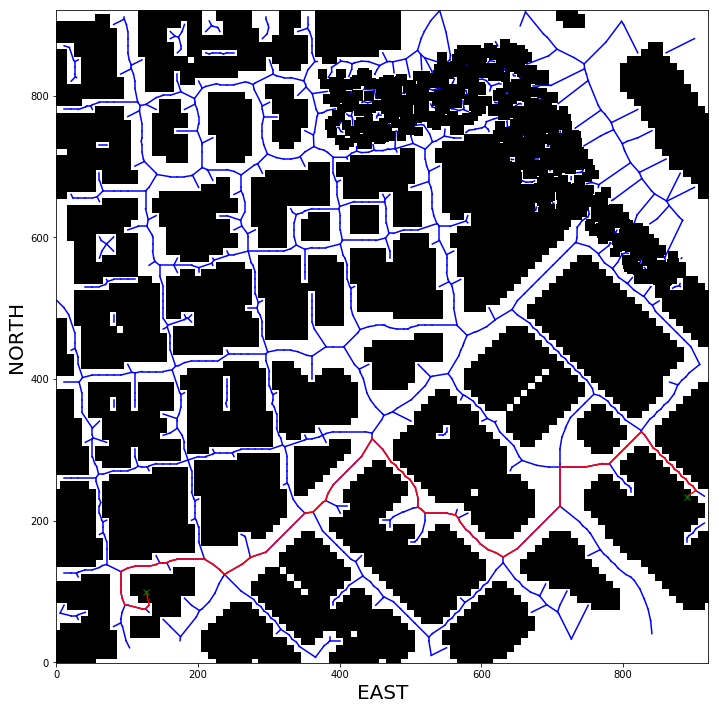

In [14]:
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
    
plt.plot([start_ne[1], start_ne_g[1]], [start_ne[0], start_ne_g[0]], 'r-')
for i in range(len(path)-1):
    p1 = path[i]
    p2 = path[i+1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'r-')
plt.plot([goal_ne[1], goal_ne_g[1]], [goal_ne[0], goal_ne_g[0]], 'r-')
    
plt.plot(start_ne[1], start_ne[0], 'gx')
plt.plot(goal_ne[1], goal_ne[0], 'gx')

plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)
plt.show()